In [2]:
import cv2
import numpy as np
import dlib
import time
import matplotlib.pyplot as plt


In [3]:
def extract_index_nparray(nparray):
    index = None
    for num in nparray[0]:
        index = num
        break
    return index

([], [])

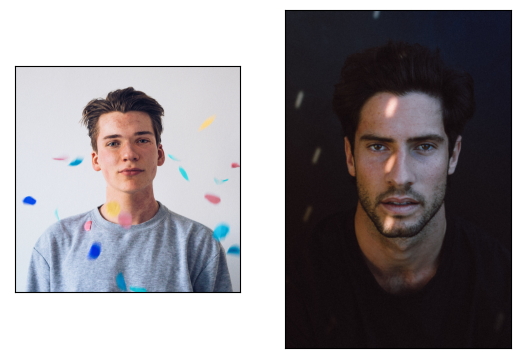

In [91]:
img = cv2.imread("media/images/imageB.jpg")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask = np.zeros_like(img_gray)
img2 = cv2.imread("media/images/imageA.jpg")
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

plt.subplot(121);plt.imshow(img[...,::-1]);plt.xticks([]);plt.yticks([])
plt.subplot(122);plt.imshow(img2[...,::-1]);plt.xticks([]);plt.yticks([])


In [92]:
img.shape

(3452, 3456, 3)

In [93]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat")

In [100]:
detector(img2_gray)

rectangles[[(496, 838) (1266, 1609)]]

In [101]:
def visualize_and_get_points(img):
    cpimg = img.copy()
    gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = detector(gray_img)
    coords = []
    landmarks_points = []
    for face in faces:
        pt1 = face.left(),face.top()
        pt2 = face.right(),face.bottom()
        coords.append([pt1,pt2])
        landmarks = predictor(gray_img,face)
        points = []
        for n in range(0,68):
            x,y = landmarks.part(n).x,landmarks.part(n).y
            points.append((x,y))
            cv2.circle(cpimg,(x,y),3,(0,255,255),5)
        cv2.rectangle(cpimg,pt1,pt2,(0,255,0),5)
        landmarks_points.append(points)
        
    # plt.imshow(cpimg[...,::-1])
    return cpimg,coords,landmarks_points

In [102]:
pr1_img,coords1 ,landmarks_points1 = visualize_and_get_points(img)
pr2_img,coords2 ,landmarks_points2 = visualize_and_get_points(img2)


len points1: 68   len convexHull points1 23
len points2: 68   len convexHull points2 21


([], [])

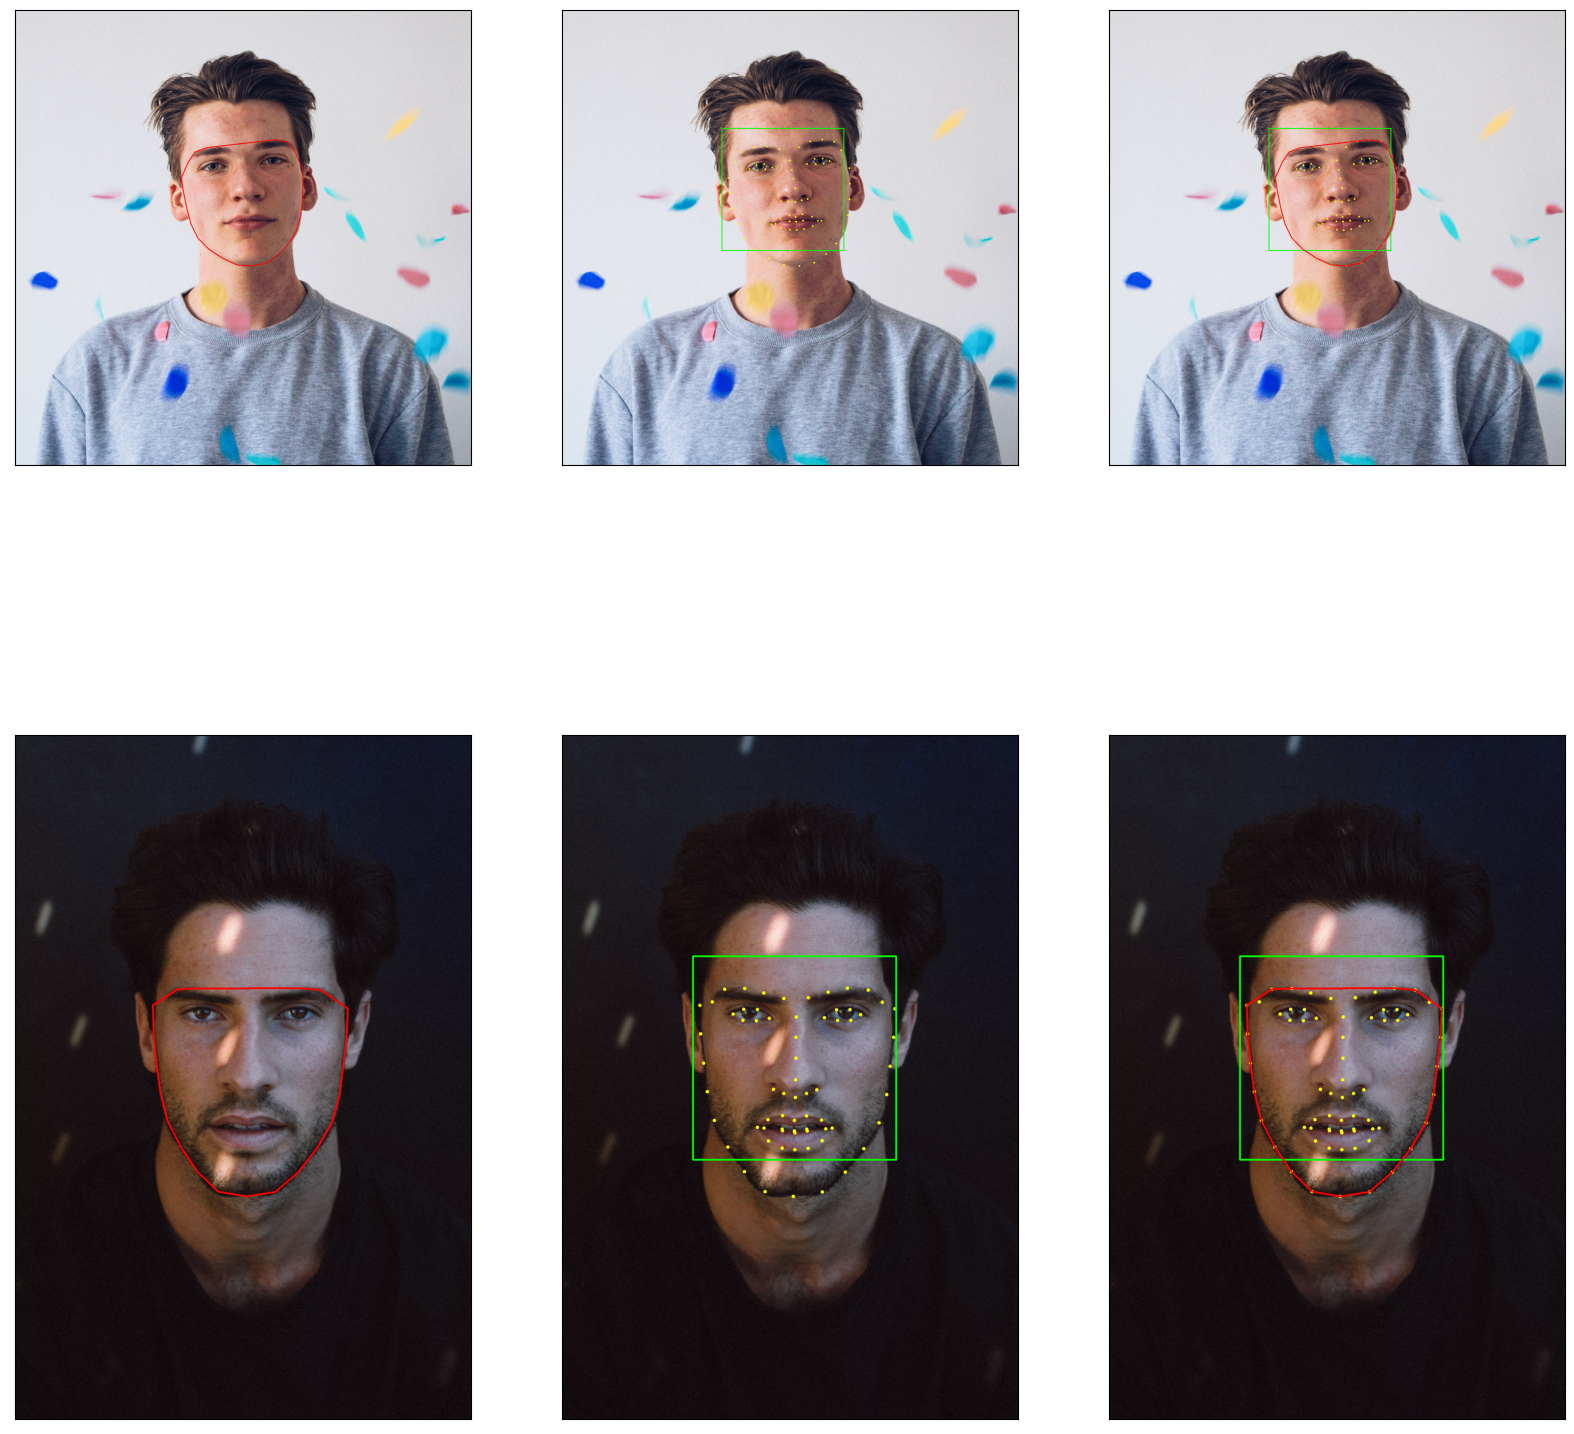

In [103]:
# Because num faces in images are 1 use landmarks_points1[0]
points1 = np.array(landmarks_points1[0],np.int32)
convex1 = cv2.convexHull(points1)
print('len points1:',len(points1),'  len convexHull points1',len(convex1))

points2 = np.array(landmarks_points2[0],np.int32)
convex2 = cv2.convexHull(points2)
print('len points2:',len(points2),'  len convexHull points2',len(convex2))

cvx_img1 = cv2.polylines(img.copy(),[convex1],True,(0,0,255),5)
cvx_img2 = cv2.polylines(img2.copy(),[convex2],True,(0,0,255),5)

con1 = cv2.polylines(pr1_img.copy(),[convex1],True,(0,0,255),5)
con2 = cv2.polylines(pr2_img.copy(),[convex2],True,(0,0,255),5)

plt.figure(figsize=(20,20))
plt.subplot(231);plt.imshow(cvx_img1[...,::-1]);plt.xticks([]);plt.yticks([])
plt.subplot(232);plt.imshow(pr1_img[...,::-1]);plt.xticks([]);plt.yticks([])
plt.subplot(233);plt.imshow(con1[...,::-1]);plt.xticks([]);plt.yticks([])

plt.subplot(234);plt.imshow(cvx_img2[...,::-1]);plt.xticks([]);plt.yticks([])
plt.subplot(235);plt.imshow(pr2_img[...,::-1]);plt.xticks([]);plt.yticks([])
plt.subplot(236);plt.imshow(con2[...,::-1]);plt.xticks([]);plt.yticks([])


([], [])

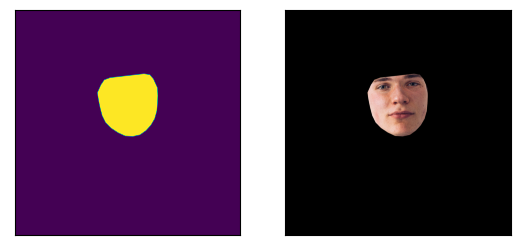

In [104]:
cv2.fillConvexPoly(mask,convex1,255)
face_mask1 = cv2.bitwise_and(img,img,mask=mask)

plt.subplot(121);plt.imshow(mask);plt.xticks([]);plt.yticks([])
plt.subplot(122);plt.imshow(face_mask1[...,::-1]);plt.xticks([]);plt.yticks([])

In [105]:
def visualize_get_triangles(img, convex_points,landmarks_points):
    points = np.array(landmarks_points[0])
    cpimg = img.copy()
    rect = cv2.boundingRect(convex_points)
    subdiv = cv2.Subdiv2D(rect)
    subdiv.insert(landmarks_points[0])
    triangles = subdiv.getTriangleList()
    triangles = np.array(triangles, dtype=np.int32)
    print('triangles len : ',len(triangles))

    indexes_triangles = []
    triangle_points = []
    for t in triangles:
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])
        pts = np.array([pt1,pt2,pt3]).reshape(-1,1,2)

        index_pt1 = np.where((points == pt1).all(axis=1))
        index_pt1 = extract_index_nparray(index_pt1)

        index_pt2 = np.where((points == pt2).all(axis=1))
        index_pt2 = extract_index_nparray(index_pt2)

        index_pt3 = np.where((points == pt3).all(axis=1))
        index_pt3 = extract_index_nparray(index_pt3)

        if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
            triangle = [index_pt1, index_pt2, index_pt3]
            indexes_triangles.append(triangle)


        cv2.polylines(cpimg, [pts], True, (255,255,255), 5)
        # triangle_points.append(pts)

    return cpimg,indexes_triangles

triangles len :  109
triangles len :  113


([], [])

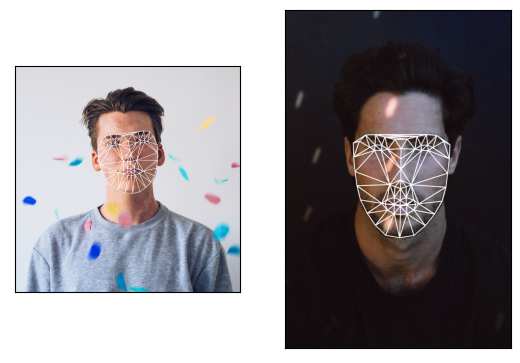

In [106]:
tr_img1 ,tr_idx1 = visualize_get_triangles(img,convex1,landmarks_points1)
tr_img2 ,tr_idx2 = visualize_get_triangles(img2,convex2,landmarks_points2)

plt.subplot(121);plt.imshow(tr_img1[...,::-1]);plt.xticks([]);plt.yticks([])
plt.subplot(122);plt.imshow(tr_img2[...,::-1]);plt.xticks([]);plt.yticks([])

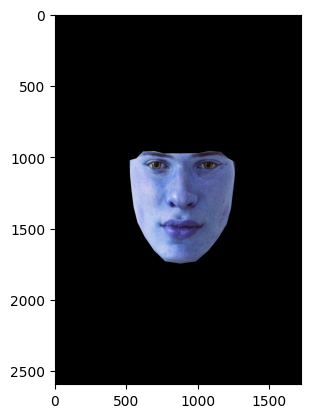

In [108]:
new_face = np.zeros_like(img2,np.uint8)

line_mask1 = np.zeros_like(img_gray)
face_mask2 = np.zeros_like(img2)

for index in tr_idx1:
    
    tr1_p1 = landmarks_points1[0][index[0]]
    tr1_p2 = landmarks_points1[0][index[1]]
    tr1_p3 = landmarks_points1[0][index[2]]

    triangle1 = np.array([tr1_p1,tr1_p2,tr1_p3])
    x1,y1,w1,h1 = cv2.boundingRect(triangle1)    
    crop_tr1 = img[y1: y1 + h1, x1: x1 + w1]
    crop_mask1 = np.zeros((h1, w1), np.uint8)

    til_pt1 = np.array([[tr1_p1[0]-x1,tr1_p1[1]-y1],
                    [tr1_p2[0]-x1,tr1_p2[1]-y1],
                    [tr1_p3[0]-x1,tr1_p3[1]-y1]],np.int32)

    cv2.fillConvexPoly(crop_mask1, til_pt1, 255)
    
    cv2.line(line_mask1, tr1_p1, tr1_p2, 255)
    cv2.line(line_mask1, tr1_p2, tr1_p3, 255)
    cv2.line(line_mask1, tr1_p1, tr1_p3, 255)

    line_space1 = cv2.bitwise_and(img, img, mask=line_mask1)


    tr2_p1 = landmarks_points2[0][index[0]]
    tr2_p2 = landmarks_points2[0][index[1]]
    tr2_p3 = landmarks_points2[0][index[2]]

    triangle2 = np.array([tr2_p1,tr2_p2,tr2_p3])
    x2,y2,w2,h2 = cv2.boundingRect(triangle2)
    
    crop_tr2 = img[y2: y2 + h2, x2: x2 + w2]
    crop_mask2 = np.zeros((h2, w2), np.uint8)

    
    til_pt2 = np.array([[tr2_p1[0] - x2, tr2_p1[1] - y2],
                        [tr2_p2[0] - x2, tr2_p2[1] - y2],
                        [tr2_p3[0] - x2, tr2_p3[1] - y2]], np.int32)

    cv2.fillConvexPoly(crop_mask2, til_pt2, 255)
    
    points1 = np.float32(til_pt1)
    points2 = np.float32(til_pt2)
    M = cv2.getAffineTransform(points1, points2)
    warped_triangle = cv2.warpAffine(crop_tr1, M, (w2, h2))
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=crop_mask2)

    rect_area = new_face[y2:y2+h2, x2:x2+w2]
    # print(rect_area.shape)
    rect_area_gray = cv2.cvtColor(rect_area, cv2.COLOR_BGR2GRAY)

    _, mask_rect_area = cv2.threshold(rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_rect_area)
    rect_area = cv2.add(rect_area, warped_triangle)
    new_face[y2:y2+h2, x2:x2+w2] = rect_area
    
plt.imshow(new_face)
    

([], [])

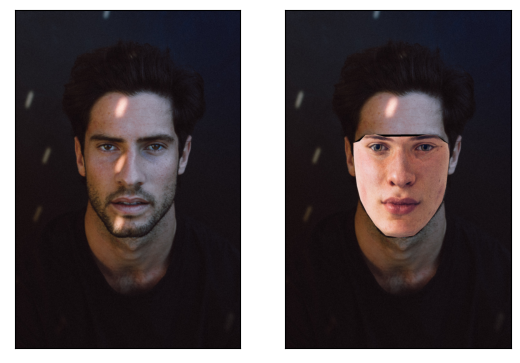

In [109]:
img2_mask = np.zeros_like(img2_gray)
img2_mask = cv2.fillConvexPoly(img2_mask, convex2, 255)
img2_face_mask = cv2.bitwise_not(img2_mask)

img2_noface = cv2.bitwise_and(img2, img2, mask=img2_face_mask)
result = cv2.add(img2_noface, new_face)

plt.subplot(121);plt.imshow(img2[...,::-1]);plt.xticks([]);plt.yticks([])
plt.subplot(122);plt.imshow(result[...,::-1]);plt.xticks([]);plt.yticks([])

In [110]:
(x, y, w, h) = cv2.boundingRect(convex2)
center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))

seamless_result = cv2.seamlessClone(result, img2, img2_mask, center_face2, cv2.NORMAL_CLONE)
cv2.imwrite('B_result_A.jpg',seamless_result)


True

#### By swapping images results are: 

([], [])

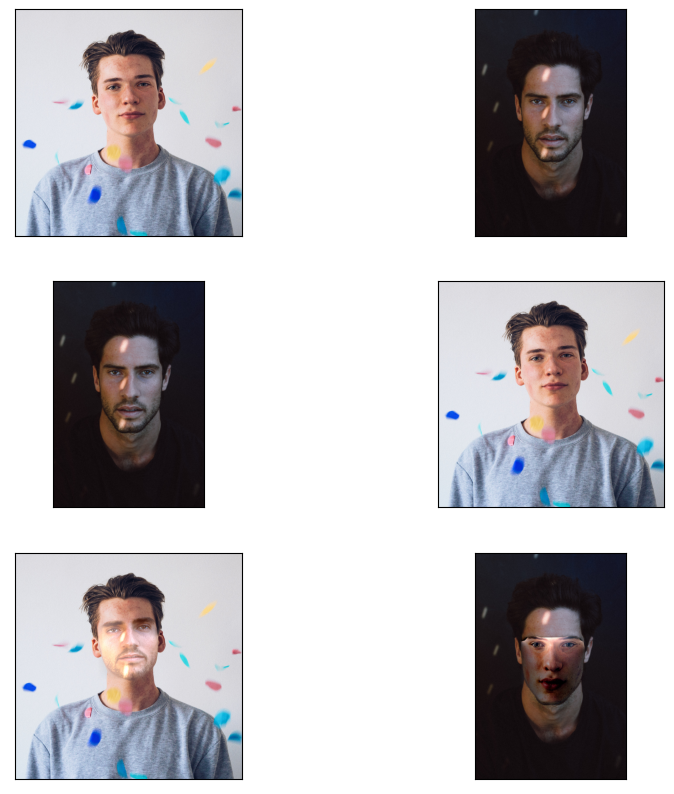

In [113]:
resultA = cv2.imread('A_result_B.jpg')
plt.figure(figsize=(10,10))
plt.subplot(321);plt.imshow(img[...,::-1]);plt.xticks([]);plt.yticks([])
plt.subplot(323);plt.imshow(img2[...,::-1]);plt.xticks([]);plt.yticks([])
plt.subplot(325);plt.imshow(resultA[...,::-1]);plt.xticks([]);plt.yticks([])

resultB = cv2.imread('B_result_A.jpg')
plt.subplot(322);plt.imshow(img2[...,::-1]);plt.xticks([]);plt.yticks([])
plt.subplot(324);plt.imshow(img[...,::-1]);plt.xticks([]);plt.yticks([])
plt.subplot(326);plt.imshow(resultB[...,::-1]);plt.xticks([]);plt.yticks([])